In [1]:
import gymnasium as gym
import bam_gym # you need to import to register
from bam_gym.utils import SampleSaver

import torch
import json

In [2]:
n_arms = 10
n_state = 1
env = gym.make("bam/ContextBandit", n_arms=n_arms, n_state=n_state, seed=1)

In [3]:
saver = SampleSaver("/home/bam/other_bam_packages/bam_gym/dataset",
                 "ContextBandit",
                 "GPU"
                 )

[SampleSaver] Resuming from /home/bam/other_bam_packages/bam_gym/dataset/ContextBandit/GPU/sarsa_0000.jsonl
[SampleSaver] Current counter: 3000, current json count: 3000


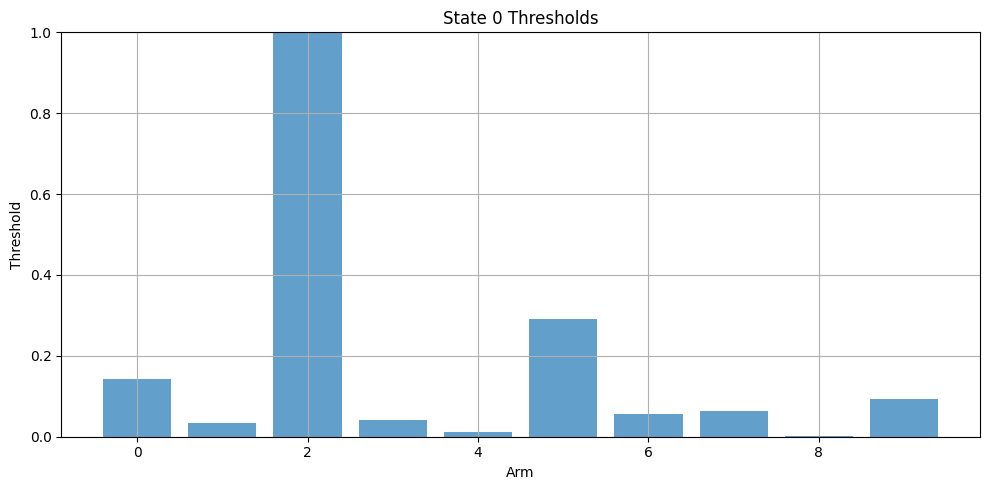

In [4]:
observation, info = env.reset()
env.render()


In [5]:
action = env.action_space.sample()

next_observation, reward, terminated, truncated, next_info = env.step(action)

print(f"\nStep Result:")
print(f"Observation: {observation}")
# print(f"Observation: (shape={observation.shape}, dtype={observation.dtype})")
print(f"Action: {action}")
print(f"Reward: {reward}")
print(f"Terminated: {terminated}")
print(f"Truncated: {truncated}")
print(f"Next Observation: {next_observation}")


Step Result:
Observation: 0
Action: 7
Reward: -1
Terminated: True
Truncated: False
Next Observation: 0


In [6]:
for _ in range(1000):
    # action = policy(observation)
    action = env.action_space.sample()

    next_observation, reward, terminated, truncated, next_info = env.step(action)
    saver.save_sample(observation, action, reward, terminated, truncated, info)

    observation = next_observation
    info = next_info

    # Env Auto resets so not needed
    # if (terminated or truncated):
    #     observation, info = env.reset()

env.close()
saver.close()


[SampleSaver] Finished saving 4000 samples.


In [7]:
dataset = []
with open('/home/bam/other_bam_packages/bam_gym/dataset/ContextBandit/GPU/sarsa_0000.jsonl', 'r') as f:
    for line in f:
        dataset.append(json.loads(line))


print(f"Loaded {len(dataset)} samples.")
print(dataset[0])

Loaded 4000 samples.
{'#': 0, 's': {'obs': 0}, 'a': 7, 'r': -1}


In [8]:
# Counting Solution
n_arms = 10
n_state = 1

reward_sum = torch.zeros((n_state, n_arms), dtype=torch.float32)
action_count = torch.zeros((n_state, n_arms), dtype=torch.float32)

for entry in dataset:
    state = entry['s']['obs']   # Assuming 'obs' is an integer state ID
    action = entry['a']
    reward = entry['r']

    reward_sum[state, action] += reward
    action_count[state, action] += 1

# Avoid division by zero
avg_reward = torch.where(
    action_count > 0,
    reward_sum / action_count,
    torch.zeros_like(reward_sum)
)

print("\nReward Sum Matrix:")
print(reward_sum)

print("\nAverage Reward Matrix:")
print(avg_reward)

# Find best action per state
for state in range(n_state):
    best_action = torch.argmax(avg_reward[state]).item()
    best_reward = avg_reward[state, best_action]
    print(f"State {state}: Best action is {best_action} with estimated average reward {best_reward:.2f}")


Reward Sum Matrix:
tensor([[-275., -380.,  404., -363., -365., -166., -339., -390., -385., -361.]])

Average Reward Matrix:
tensor([[-0.7218, -0.9548,  1.0000, -0.9578, -0.9733, -0.4049, -0.8496, -0.9070,
         -0.9847, -0.8337]])
State 0: Best action is 2 with estimated average reward 1.00


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

In [11]:
class SimpleFCN(nn.Module):
    def __init__(self, n_states, n_actions):
        super().__init__()

        # One-hot input → output actions
        self.fc = nn.Linear(n_states, n_actions, bias=False)  # no bias to match pure s x n weight

    def forward(self, state_index):
        # Convert state index to one-hot
        one_hot = torch.nn.functional.one_hot(state_index, num_classes=self.fc.in_features).float()
        output = self.fc(one_hot)
        return output

In [ ]:
model = SimpleFCN(n_state, n_arms)


In [18]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)


https://stats.stackexchange.com/questions/249355/how-exactly-to-compute-deep-q-learning-loss-function

In [15]:
print(model.fc.weight.data)


tensor([[ 0.8855],
        [ 0.4967],
        [ 0.1392],
        [-0.3133],
        [-0.0713],
        [-0.5528],
        [ 0.1615],
        [-0.3174],
        [-0.9967],
        [-0.2480]])


In [ ]:
for i in range(1000):
    batch_size = 1

    shuffled_indices = torch.randperm(len(dataset))

    for start_idx in range(0, len(dataset), batch_size):
        batch_indices = shuffled_indices[start_idx:start_idx + batch_size]
        batch = [dataset[i] for i in batch_indices]

        # Extract tensors
        states = torch.tensor([b['s']['obs'] for b in batch], dtype=torch.long)
        actions = torch.tensor([b['a'] for b in batch], dtype=torch.long)
        rewards = torch.tensor([b['r'] for b in batch], dtype=torch.float32)

        # Forward pass
        logits = model(states)  # (batch_size, n_actions)

        # For Q-learning: treat logits directly as Q-values
        q_values = logits  # (batch_size, n_actions)
        print(q_values)
        # Get the predicted Q-value for the action taken
        selected_q_values = q_values[torch.arange(len(batch)), actions]

        # Q-learning Loss = (Q_predicted - reward)^2
        loss = torch.nn.functional.mse_loss(selected_q_values, rewards)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(f"Loss: {loss:.4f}")
        break
    break


tensor([[-0.7218, -0.9548,  1.0000, -0.9578, -0.9744, -0.4285, -0.8526, -0.9070,
         -0.9850, -0.8370]], grad_fn=<MmBackward0>)
Loss: 0.0774


In [ ]:
print(avg_reward)
print(q_values)
print(q_values- avg_reward)

# They are basically exactly equal! There are many ways to calculate a moving average online...
# Q learning looks alot like calculating a moving average with fixed step size... (See RL book)
# You are basically counting in a soft way

tensor([[-0.7218, -0.9548,  1.0000, -0.9578, -0.9733, -0.4049, -0.8496, -0.9070,
         -0.9847, -0.8337]])
tensor([[-0.7218, -0.9548,  1.0000, -0.9578, -0.9744, -0.4285, -0.8526, -0.9070,
         -0.9850, -0.8370]], grad_fn=<MmBackward0>)
tensor([[ 3.5763e-07, -4.2915e-06, -9.5367e-07,  2.3842e-07, -1.0582e-03,
         -2.3604e-02, -3.0113e-03,  5.0664e-06, -3.0273e-04, -3.3198e-03]],
       grad_fn=<SubBackward0>)
